# This notebook is for the initial creation and preprocessing of the data. The raw data is taken from the "historia-buses" text files

Table of contents <a id='top'>

1. [Getting a DataFrame](#getting)
1. [Trayectos por Línea](#trayectos)

In [78]:
import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

PATHS_JSON = os.path.join(DATA_RAW, 'trayectosporlinea.json')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

## 1. Getting a DataFrame <a id='getting'>
[Top](#top)

In [2]:
def parse_bus(bus):
    """ Parses one record. """
    bus_dict = dict()
    bus_dict['x'] = bus['geometry']['coordinates'][0]
    bus_dict['y'] = bus['geometry']['coordinates'][1]
    bus_dict['codigoBus'] = bus['properties']['codigoBus']
    bus_dict['linea'] = bus['properties']['linea']
    bus_dict['uid'] = str(bus_dict['linea']) + '_' + str(bus_dict['codigoBus'])
    return bus_dict

In [80]:
def parse_time(timestr):
    """ Converts a time string to datetime. Ignores the sub-second part. """
    return dt.datetime.strptime(timestr.split('.')[0], '%Y-%m-%dT%H:%M:%S')

In [81]:
def parse_line(line):
    """ Parses all the records for one timestamp. """
    record = json.loads(line.replace('\n',''))
    data = list()
    timestamp = parse_time(record['timestamp'])
    bus_records = record['posiciones']['features']
    for bus in bus_records:
        bus_dict = parse_bus(bus)
        bus_dict['timestamp'] = timestamp
        data.append(bus_dict)
    return data

In [82]:
def parse_file(filepath, parse_line=parse_line):
    """ Returns a DataFrame with all the relevant data from a txt input file. """
    with open(filepath, 'r') as file:
        lines = file.readlines()
    data = list()
    for line in lines:
        data += parse_line(line)
    return pd.DataFrame(data)

In [83]:
def parse_data(root_dir=ROOT_DIR, concat=True):
    """ 
    If concat = False, returns a list of DataFrames, one for each txt input file in the 
    RAW dir.
    If concat=True, it returns a concatenated DataFrame with all the data.
    """
    data_dir = os.path.join(root_dir, 'data')
    data_raw = os.path.join(data_dir, 'raw')
    txt_paths = ['historia-buses.txt'] + ['historia-buses{}.txt'.format(i) for i in range(1,4)]
    txt_paths = [os.path.join(data_raw, name) for name in txt_paths]
    data = list()
    for path in txt_paths:
        data.append(parse_file(path))
    if concat:
        return pd.concat(data, ignore_index=True)
    return data

### Let's look at the individual dataframes

In [84]:
data_list = parse_data(concat=False)

In [85]:
df = data_list[0]
df1 = data_list[1]
df2 = data_list[2]
df3 = data_list[3]

In [86]:
print(df.shape)
df.head()

(181914, 5)


codigoBus linea           timestamp          x          y
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000

In [87]:
type(df.timestamp[0])

pandas._libs.tslib.Timestamp

In [88]:
print(df1.shape)
df1.head()

(4897, 5)


codigoBus  linea           timestamp          x          y
0         26  22426 2018-09-26 13:18:22 -56.230015 -34.829420
1        100  22426 2018-09-26 13:18:22 -56.165480 -34.911400
2         79   2220 2018-09-26 13:18:22 -56.158800 -34.922432
3         40   2183 2018-09-26 13:18:22 -56.197420 -34.876884
4         86  22426 2018-09-26 13:18:22 -56.198067 -34.876415

In [89]:
print(df2.shape)
df2.head()

(45990, 5)


codigoBus  linea           timestamp          x          y
0        485  17902 2018-09-28 17:41:19 -56.110750 -34.885000
1       1056  42388 2018-09-28 17:41:19 -56.176420 -34.900066
2         13  12390 2018-09-28 17:41:19 -56.207417 -34.905420
3         12  37517 2018-09-28 17:41:19 -56.151634 -34.911083
4        637  17919 2018-09-28 17:41:19 -56.118110 -34.870000

In [90]:
print(df3.shape)
df3.head()

(17238, 5)


codigoBus linea           timestamp          x          y
0         25  2409 2018-10-01 19:04:16 -56.196335 -34.906250
1         41   217 2018-10-01 19:04:16 -56.203550 -34.870667
2         57   540 2018-10-01 19:04:16 -56.147305 -34.878860
3        671  7902 2018-10-01 19:04:16   0.000000   0.000000
4       1076  7902 2018-10-01 19:04:16 -56.111390 -34.882668

In [91]:
df.timestamp.apply(lambda x: x.day).unique()

array([2])

In [92]:
df1.timestamp.apply(lambda x: x.day).unique()

array([26])

In [93]:
df2.timestamp.apply(lambda x: x.day).unique()

array([28])

In [94]:
df3.timestamp.apply(lambda x: x.day).unique()

array([1])

So, the different dataframes correspond to different days

### And now, the complete dataframe

In [95]:
data_df = parse_data()

In [96]:
print(data_df.shape)
data_df.head()

(250039, 5)


codigoBus linea           timestamp          x          y
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000

### Let's save it

In [97]:
data_df.to_pickle(os.path.join(DATA_INTERIM, 'data.pkl'))

In [98]:
data_df.to_csv(os.path.join(DATA_INTERIM, 'data.csv'))

## 1. Trayectos por Línea <a id='trayectos'>
[Top](#top)

In [99]:
def get_paths(path_to_file=PATHS_JSON):
    """ Loads and parses the file 'trayectosporlinea.json' """
    paths = pd.read_json(path_to_file)
    paths = pd.DataFrame(paths.values.flatten().tolist()).dropna()
    paths = paths.astype({'codigoParada': int,
                      'lat': float,
                      'long': float,
                      'ordinal': int})  # linea may not be an integer (e.g.: D11)
    return paths

In [100]:
paths = get_paths()
print(paths.shape)
paths.head()

(5697, 7)


calle  codigoParada           esquina        lat  \
0  AV DRA MA L SALDUN DE RODRIGUEZ          4836        AV BOLIVIA -34.881817   
1                       AV BOLIVIA          2953       JOSE ORDEIG -34.879045   
2                       AV BOLIVIA          2954            VERONA -34.877140   
3                       AV BOLIVIA          2955  DR ELIAS REGULES -34.875377   
4                       AV BOLIVIA          2956          CALLE N1 -34.873713   

  linea       long  ordinal  
0   217 -56.083301        1  
1   217 -56.085743        2  
2   217 -56.088758        3  
3   217 -56.091500        4  
4   217 -56.094133        5

In [101]:
paths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5696
Data columns (total 7 columns):
calle           5697 non-null object
codigoParada    5697 non-null int64
esquina         5697 non-null object
lat             5697 non-null float64
linea           5697 non-null object
long            5697 non-null float64
ordinal         5697 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 356.1+ KB


In [102]:
def get_line_path(paths, line):
    """ Gets the complete path for a given line. """
    return paths[paths.linea == str(line)]

Let's check the paths

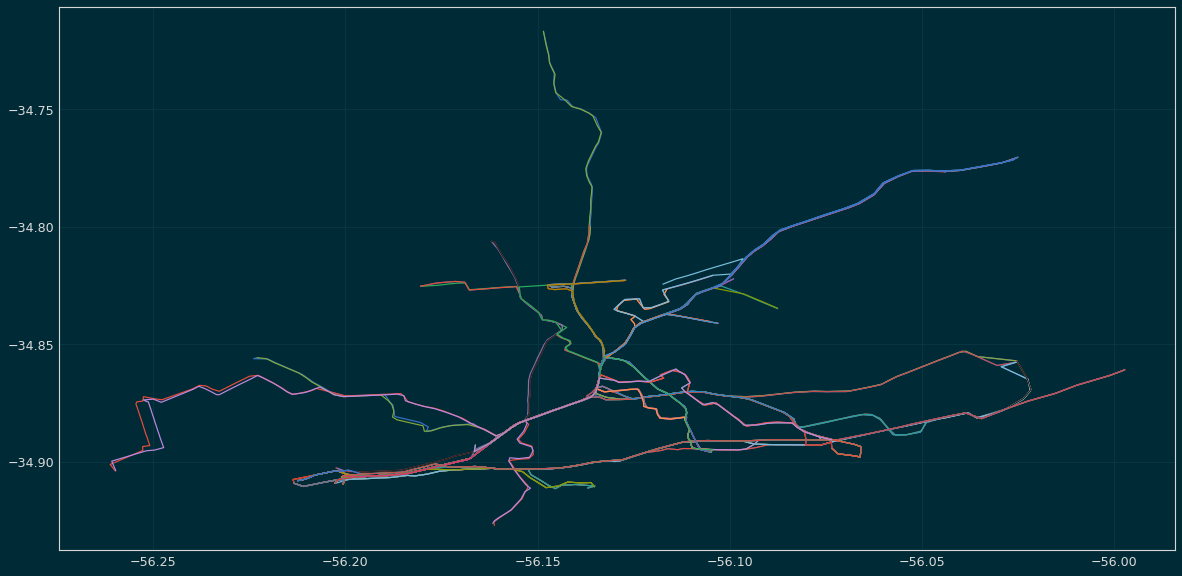

In [103]:
for line in paths.linea.unique():
    path = get_line_path(paths, line)
    plt.plot(path.long, path.lat)

It looks like they are real paths from Montevideo buses (the shape of the bay, the old city, and the main avenues can be recognised), but the line numbers were changed. We'll see that in later notebooks.

### Let's save the paths

In [104]:
paths.to_pickle(os.path.join(DATA_PROCESSED, 'paths.pkl'))